# Анализ входящих звонков одного оператора

In [42]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [43]:
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [44]:
calls=pd.read_excel('C:/Users/Natalya/Desktop/Учёба/Детализация_213211553690_20241209.xlsx')

## Изучаем и предобрабатываем полученный отчёт от сотового оператора.

In [45]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Аб. номер                                 1494 non-null   int64  
 1   Тип лицевого счета                        1494 non-null   object 
 2   Номер лицевого счета                      1494 non-null   int64  
 3   Номер устройства (IMEI)                   1313 non-null   float64
 4   Дата                                      1494 non-null   object 
 5   Время                                     1494 non-null   object 
 6   Вид услуги                                1494 non-null   object 
 7   Набранный номер, точка доступа            1390 non-null   object 
 8   Местонахождение при использовании услуги  1392 non-null   object 
 9   Объём                                     1392 non-null   float64
 10  Единицы измерения                   

### Во избежание разглашения конфиденциальной информации, часть цифр в номерах заменяем на звездочки

In [46]:
calls['Аб. номер']=calls['Аб. номер'].astype(str)
calls['Номер лицевого счета']=calls['Номер лицевого счета'].astype(str)
calls['Набранный номер, точка доступа']=calls['Набранный номер, точка доступа'].astype(str)

for i in range(len(calls)):
    calls['Аб. номер'][i]=calls['Аб. номер'][i][:-4]+'****' 
    calls['Набранный номер, точка доступа'][i]=calls['Набранный номер, точка доступа'][i][:-4]+'****' 
    calls['Номер лицевого счета'][i]=calls['Номер лицевого счета'][i][:-4]+'****' 


In [47]:
calls.head()

,Аб. номер,Тип лицевого счета,Номер лицевого счета,Номер устройства (IMEI),Дата,Время,Вид услуги,"Набранный номер, точка доступа",Местонахождение при использовании услуги,Объём,Единицы измерения,"Стоимость, руб","Полная стоимость, руб","Оплачено с бонусного баланса, руб"
0,926445****,основной,21321155****,NaN,01.09.2024,16:51:44,АП за МегаФон Защита 2,****,NaN,NaN,NaN,0.0,0.0,0
1,926445****,основной,21321155****,NaN,01.09.2024,16:51:44,АП за услугу - Кто звонил +,****,NaN,NaN,NaN,0.0,0.0,0
2,926445****,основной,21321155****,NaN,02.09.2024,16:51:44,АП за МегаФон Защита 2,****,NaN,NaN,NaN,0.0,0.0,0
3,926445****,основной,21321155****,NaN,02.09.2024,16:51:44,АП за услугу - Кто звонил +,****,NaN,NaN,NaN,0.0,0.0,0
4,926445****,основной,21321155****,NaN,03.09.2024,16:51:44,АП за МегаФон Защита 2,****,NaN,NaN,NaN,0.0,0.0,0


#### Оставляем только нужные столбцы и строки, переименовываем их, приводим к нужному формату.

In [48]:
calls=calls[['Дата','Время','Вид услуги','Набранный номер, точка доступа','Объём']]

In [49]:
calls.rename(columns={'Набранный номер, точка доступа':'Входящий номер','Объём':'Длительность (сек.)'},inplace=True)

In [50]:
calls['Дата']=pd.to_datetime(calls['Дата'], format="%d.%m.%Y")
calls['Час']=pd.to_datetime(calls['Время'], format="%H:%M:%S").dt.hour

In [51]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Дата                 1494 non-null   datetime64[ns]
 1   Время                1494 non-null   object        
 2   Вид услуги           1494 non-null   object        
 3   Входящий номер       1494 non-null   object        
 4   Длительность (сек.)  1392 non-null   float64       
 5   Час                  1494 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(3)
memory usage: 64.3+ KB


In [52]:
calls=calls[calls['Вид услуги'].str.contains('Вх. ')]

In [53]:
calls.reset_index(drop=True, inplace=True)

#### Так как график суточный, звонки полученные с 00:00 до 8:00 будут относиться к смене предыдущего дня.

In [54]:
calls.loc[(calls['Время'] >'08:00:00')&(calls['Время'] <'23:59:59'),'день/ночь']='день'
calls.loc[calls['Время'] <'07:59:59','день/ночь']='ночь'

In [55]:
calls['Дата сутки']=pd.NA
for i in range(len(calls)):
    if calls['день/ночь'][i]=='день':
        calls['Дата сутки'][i]=calls['Дата'][i]
        #обнять промежутое времени (сутки) 
    if calls['день/ночь'][i]=='ночь':
        calls['Дата сутки'][i]=(calls['Дата'][i]-timedelta(days=1))
    
calls['Дата сутки']=pd.to_datetime(calls['Дата сутки']).dt.date

In [56]:
calls['День недели'] = pd.to_datetime(calls['Дата сутки']).dt.weekday
calls.loc[calls['День недели']==0,'День недели']='понедельник'
calls.loc[calls['День недели']==1,'День недели']='вторник'
calls.loc[calls['День недели']==2,'День недели']='среда'
calls.loc[calls['День недели']==3,'День недели']='четверг'
calls.loc[calls['День недели']==4,'День недели']='пятница'
calls.loc[calls['День недели']==5,'День недели']='суббота'
calls.loc[calls['День недели']==6,'День недели']='воскресенье'

In [57]:
calls['Дата сутки']=calls['Дата сутки'].astype(str)

In [58]:
calls['Сутки+день недели']=calls['Дата сутки']+' '+calls['День недели']
    

In [59]:
calls['Дата сутки']=pd.to_datetime(calls['Дата сутки'])

In [60]:
calls['месяц'] = pd.to_datetime(calls['Дата сутки']).dt.month
calls.loc[calls['месяц']==10,'месяц']='октябрь'
calls.loc[calls['месяц']==11,'месяц']='ноябрь'

#### Проверяем на наличие пропущенных значений и дубликатов

In [61]:
calls.isnull().sum()

Дата                   0
Время                  0
Вид услуги             0
Входящий номер         0
Длительность (сек.)    0
Час                    0
день/ночь              0
Дата сутки             0
День недели            0
Сутки+день недели      0
месяц                  0
dtype: int64

In [62]:
calls[['Дата','Время']].duplicated().sum()

4

#### Пропущенных значений нет, есть 4 дубликата, удаляем их

In [63]:
calls.drop_duplicates(subset=['Дата','Время'],inplace=True)

####  Выбираем только данные за октябрь и ноябрь с информацией по входящим звонкам.

In [64]:
calls=calls[calls['Вид услуги'].str.contains('Вх. ')]
calls=calls[calls['Дата сутки'].between('2024-10-01','2024-11-30')]
calls.reset_index(drop=True, inplace=True)

In [65]:
calls.head()

,Дата,Время,Вид услуги,Входящий номер,Длительность (сек.),Час,день/ночь,Дата сутки,День недели,Сутки+день недели,месяц
0,2024-10-03,09:30:06,Вх. с МегаФон другого региона; Брянская Облас...,7900366****,52.0,9,день,2024-10-03,четверг,2024-10-03 четверг,октябрь
1,2024-10-03,09:33:22,Вх. междугородний с моб. номеров РФ; Республик...,7912181****,28.0,9,день,2024-10-03,четверг,2024-10-03 четверг,октябрь
2,2024-10-03,10:28:13,Вх. междугородний с моб. номеров РФ; Забайкаль...,7914444****,100.0,10,день,2024-10-03,четверг,2024-10-03 четверг,октябрь
3,2024-10-03,10:39:27,Вх. междугородний с моб. номеров РФ; Республик...,7978516****,45.0,10,день,2024-10-03,четверг,2024-10-03 четверг,октябрь
4,2024-10-03,11:05:00,Вх. междугородний с моб. номеров РФ; Хабаровск...,7924300****,70.0,11,день,2024-10-03,четверг,2024-10-03 четверг,октябрь


**Вывод:**

В результате предобработки были удалены столбцы с ненужной для анализа информацией. Добавлены столбцы с указанием часа звонка, времени суток, дня недели, месяца, а также датой начала рабочих суток. Удалены четыре дубликата. Для дальнейшего анализа выбираем данные за октябрь и ноябрь.

# Анализ входящих звонков за октябрь и ноябрь. 

**Рассмотрим распределение по месяцам**

месяц
октябрь    445
ноябрь     437
Name: count, dtype: int64


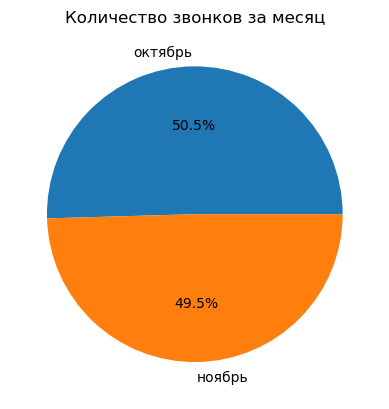

In [66]:
print(calls['месяц'].value_counts())

calls['месяц'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Количество звонков за месяц")
plt.ylabel('')
plt.show()

**Видим, что за 2 месяца было примерно одинаковое количество звонков (в октябре 444, в ноябре 436)**

**Рассмотрим распределение по дням**

In [67]:
calls['Сутки+день недели'].value_counts()

Сутки+день недели
2024-11-13 среда          69
2024-11-07 четверг        61
2024-10-24 четверг        57
2024-10-03 четверг        55
2024-11-25 понедельник    53
2024-10-31 четверг        53
2024-11-28 четверг        52
2024-11-15 пятница        49
2024-10-14 понедельник    48
2024-10-29 вторник        45
2024-11-11 понедельник    44
2024-11-21 четверг        44
2024-10-21 понедельник    42
2024-10-10 четверг        42
2024-10-17 четверг        41
2024-11-18 понедельник    40
2024-10-07 понедельник    34
2024-10-26 суббота        27
2024-11-04 понедельник    24
2024-10-15 вторник         1
2024-11-30 суббота         1
Name: count, dtype: int64

**Видим, что есть два дня с аномальных дня с одним звонком, удалим их**

In [68]:
calls=calls.drop(calls[(calls['Сутки+день недели']=='2024-11-30 суббота')|(calls['Сутки+день недели']=='2024-10-15 вторник')].index)

In [69]:
calls['Сутки+день недели'].value_counts().median()

45.0

**Медианное количество звонков в день 45**

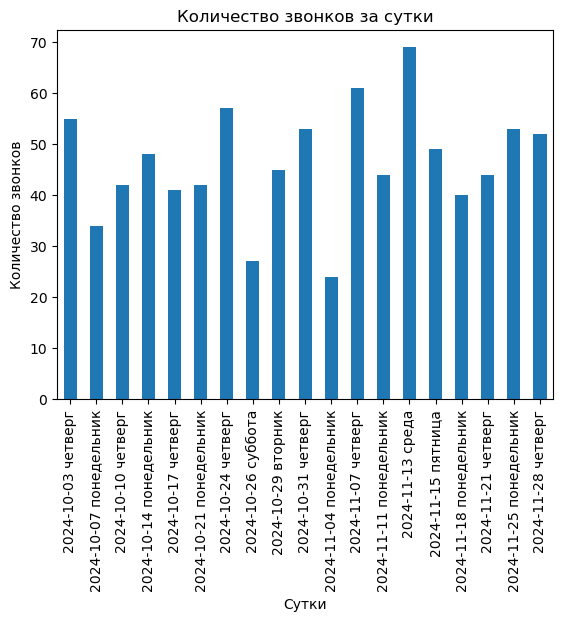

In [70]:
calls['Сутки+день недели'].value_counts(sort=False).plot.bar()
plt.title("Количество звонков за сутки")
plt.xlabel("Сутки")
plt.ylabel("Количество звонков")
plt.show()

In [71]:
print("Всего отработанно смен за два месяца:",calls.groupby(['День недели'])['Дата сутки'].nunique().sum())
calls.groupby(['День недели'])['Дата сутки'].nunique()

Всего отработанно смен за два месяца: 19


День недели
вторник        1
понедельник    7
пятница        1
среда          1
суббота        1
четверг        8
Name: Дата сутки, dtype: int64

День недели
вторник        45.0
понедельник    41.0
пятница        49.0
среда          69.0
суббота        27.0
четверг        51.0
Name: День недели, dtype: float64


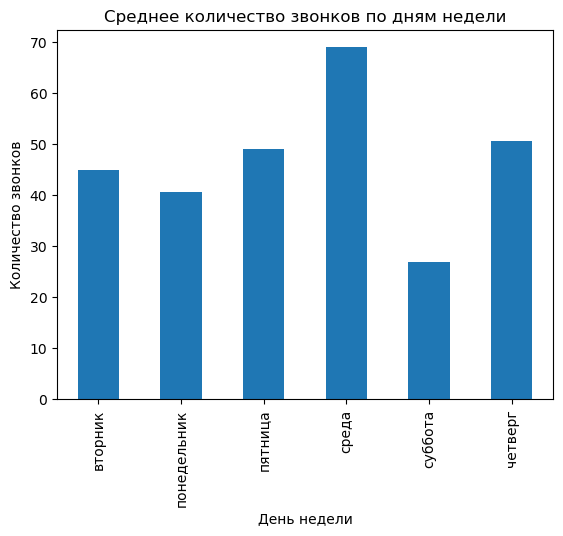

In [72]:
print(calls.groupby(['День недели','Дата сутки'])['День недели'].count().groupby('День недели').mean().round())
calls.groupby(['День недели','Дата сутки'])['День недели'].count().groupby('День недели').mean().plot.bar()
plt.title("Среднее количество звонков по дням недели")
plt.ylabel("Количество звонков")
plt.show()

**Вывод:**
- Больше всего было звонков в среду (69), меньше всего в субботу(27), однако, по этим дням недели было только по одной смене за два месяца, поэтому данные могут быть не репрезентативны
- Данных по звонкам по понедельникам и четвергам намного больше. В понедельник обычно 41 звонок в день, в четверг 51 звонок. 



# Анализ длительности звонков

In [73]:
print('Медианное значение длительности звонка',calls['Длительность (сек.)'].median(),"секунды")

Медианное значение длительности звонка 52.0 секунды


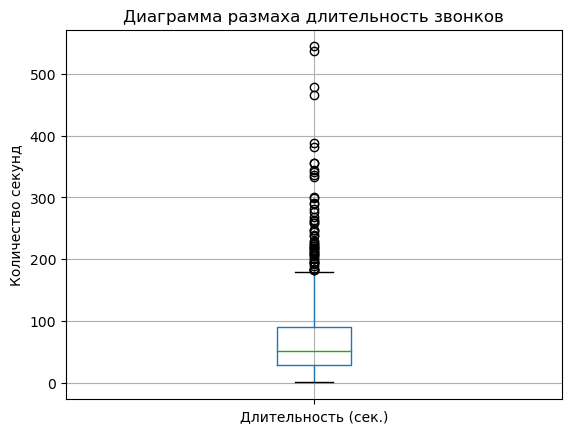

In [74]:
calls.boxplot(column='Длительность (сек.)')
plt.title("Диаграмма размаха длительность звонков")
plt.ylabel("Количество секунд")
plt.show()

Видим, что есть аномально длинные звонки. Разделим значения длительности звонков на группы:

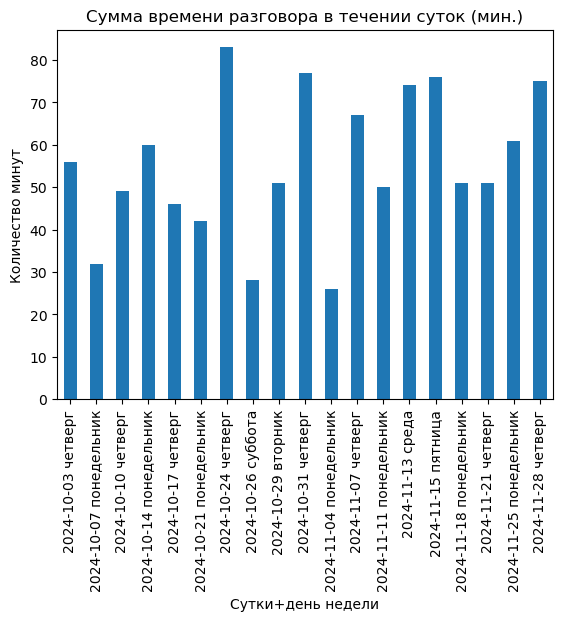

In [75]:
round(calls.groupby(['Сутки+день недели'])['Длительность (сек.)'].sum()/60).plot.bar()
plt.title('Сумма времени разговора в течении суток (мин.)')
plt.ylabel('Количество минут')
plt.show()


In [76]:
t=round(calls.groupby(['Сутки+день недели'])['Длительность (сек.)'].sum()/60)
t=t.reset_index()
t['Длительность (сек.)'].describe().round()


count    19.0
mean     56.0
std      17.0
min      26.0
25%      48.0
50%      51.0
75%      70.0
max      83.0
Name: Длительность (сек.), dtype: float64

#### Среднее суммарное количество времени потраченное за звонки за сутки 56 минут.

In [77]:
calls.loc[calls['Длительность (сек.)']<30,'Группа длительности']='до 30 секунд'
calls.loc[(calls['Длительность (сек.)']>=30)&(calls['Длительность (сек.)']<60),'Группа длительности']='от 30 сек. до 1 мин.'
calls.loc[(calls['Длительность (сек.)']>=60)&(calls['Длительность (сек.)']<120),'Группа длительности']='от 1 до 2 мин.'
calls.loc[(calls['Длительность (сек.)']>=120)&(calls['Длительность (сек.)']<180),'Группа длительности']='от 2 до 3 мин.'
calls.loc[calls['Длительность (сек.)']>=180,'Группа длительности']='более 3-х минут'

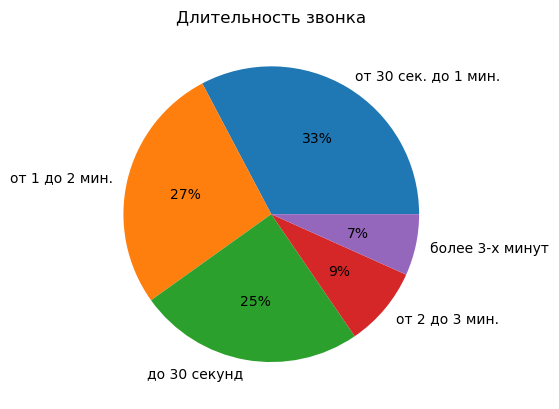

In [78]:
calls['Группа длительности'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title("Длительность звонка")
plt.ylabel('')
plt.show()

**Вывод:**

Медианное значение длительности одного звонка 52 секунды. Среднее суммарное количество времени потраченное за звонки за сутки 56 минут. 85% звонков длиться до 2 минут.

# Изучим время, в которое поступают звонки:

In [79]:
date=[]
hour=[]
count_calls=[]
for i in calls['Дата сутки'].unique():
    for h in range(0,24):
        a=len(calls[(calls['Дата сутки']==i)&( calls['Час']==h)])
        date.append(i)
        hour.append(h)
        count_calls.append(a)

df_calls = pd.DataFrame({'Дата': date, 'Час': hour, 'Количество звонков': count_calls})        

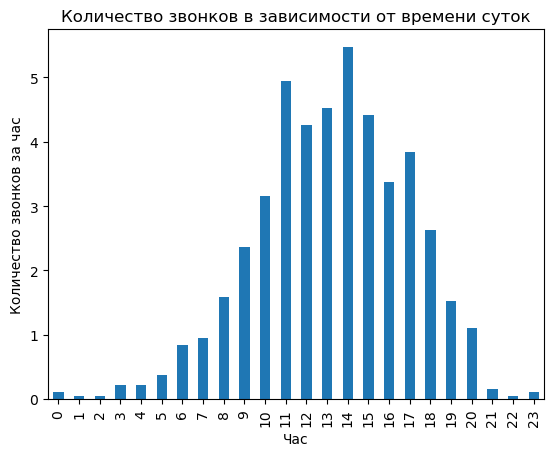

In [80]:
df_calls.groupby('Час')['Количество звонков'].mean().plot.bar()
plt.title("Количество звонков в зависимости от времени суток")
plt.ylabel("Количество звонков за час")
plt.show()

**Видим, что большая часть звонков поступает с 11 до 18 часов**

**Изучим количество звонков, поступающих с ночное время (с 00:00 до 8:00)**

In [81]:
df_calls.loc[(df_calls['Час']>=0)&(df_calls['Час']<8)].groupby('Дата')['Количество звонков'].sum()

Дата
2024-10-03    3
2024-10-07    4
2024-10-10    3
2024-10-14    1
2024-10-17    4
2024-10-21    3
2024-10-24    3
2024-10-26    6
2024-10-29    5
2024-10-31    2
2024-11-04    2
2024-11-07    1
2024-11-11    1
2024-11-13    6
2024-11-15    1
2024-11-18    2
2024-11-21    2
2024-11-25    0
2024-11-28    4
Name: Количество звонков, dtype: int64

In [82]:
print('Среднее количество звонков на ночь:',df_calls.loc[(df_calls['Час']>=0)&(df_calls['Час']<8)].groupby('Дата')['Количество звонков'].sum().median())

Среднее количество звонков на ночь: 3.0


# Вывод по анализу отчёта по входящим звонкам за октябрь и ноябрь 
### (одного оператора)

- Медианное количество звонков за сутки 45
- За два месяца было отработано 19 смен из них 7 в понедельник, 8 в четверг. Также были по одной смене во вторник, пятницу, среду, субботу
- Среднее количество звонков в понедельник 41, в четверг 51
- Медианное значение длительности звонка одного звонка 52 секунды. 85% звонков длиться до 2 минут
- Среднее суммарное количество времени потраченное за звонки за сутки 56 минут
- Большая часть звонков поступает с 11 до 18 часов
- Среднее количество звонков на ночь 3
